# Modeling COVID-19 epidemic with Python - Regional Breakdown
 

### Introduction
In this tutorial I show how to model regional COVID-19 epidemic trends with Python, using some open source data science libraries such as Pandas, Matplotlib and Scikit-learn. This has been possible thanks to the effort made by the Italian Civil Protection to publish daily data at different scales (national, regional and provincial base), and especially to release it in machine-readable format through their official GitHub repository. 

First, let's import the necessary libraries.

In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.metrics import max_error
import math
import numpy as np
from sklearn import linear_model

### Background
In [this tutorial](https://github.com/Andrampa/covid_analysis/blob/master/Modeling_COVID19_epidemic_with_Python.ipynb) I already demonstrated several biases in the dataset which make the epidemic hard to me modeled. The main finding of that study has been the following: the combined value of intensive care and daily deaths can be a reliable variable for estimating the current epidemic progression, and for modeling future trends. Let's create a new field gravi_deceduti, calculate the sum of patients in severe distress with daily deaths, and plot the resulting values.

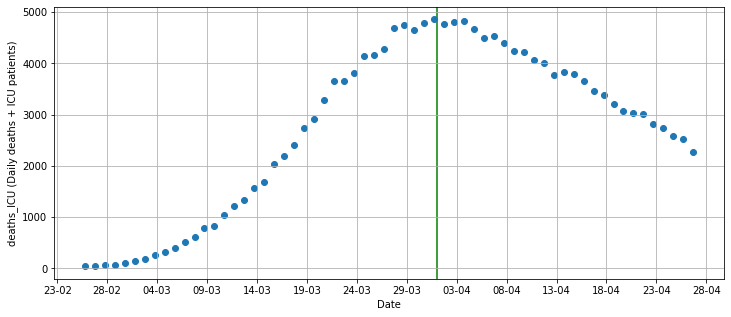

In [2]:
##why we start considering the trend after April 1st
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
data['diff_deceduti'] = data['deceduti'].diff()
dates = data['data']
data['deaths_ICU'] = data['diff_deceduti'] + data['terapia_intensiva']
variable = 'deaths_ICU'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
date_format = [pd.to_datetime(d) for d in dates]
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel='deaths_ICU (Daily deaths + ICU patients)')#,title="Trend of daily deaths +")
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
ax.axvline(datetime(2020, 4, 1), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()

In that tutorial, I also showed how to create a Linear Regression model based on that variable, and to estimate the end of the epidemic in Italy. According that model, the end of the epidemic should occur between 19th and 22nd May 2020, considering the country as a whole. However,  we know that northern regions have been by far the worst affected since the beginning of the outbreak; moreover, some regions may recover faster than others. The date predicted by the model could be a sort of average of the 20 regions' dates.
For this reason, today we will push the analysis a little bit further by developing a separate model for each Italian region. 
Then, we will join the temporal information (when it will end?) with the spatial component (where it will end first?), and create a composite regional map showing the time-table of the epidemic end.
### Importing and cleaning the data
First, let's import the necessary libraries and the COVID-19 regional breakdown provided by the Italian Civil Protection

In [3]:
#data for Trentino Alto Adige is split into 2 cateorgires (province of Bolzano and province of Trento), given their autonomous status
#they have different 'region name' but the same 'region code'
#it is an anomaly, and this unconsistency needs to be fixed in order to be mapped correctly.
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
print(df.columns)

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'casi_testati', 'note_it',
       'note_en'],
      dtype='object')


This dataset contains already about 1200 rows. Unfortunately, the data is not exactly provided in the format we need. In fact, because of some institutional reasons only 19 regions out of 20 are providing daily updates to the Civil Protection. Trentino Alto Adige (region n. 4 in the dataset) is represented by its 2 provinces separately (Provincia Autonoma di Bolzano and Provincia Autonoma di Trento). As a consequence, the dataset reports data for 19 regions and 2 provinces. Therefore, the first thing to do, is to exclude all the rows referring to region 4 from the dataset. Then, we create a second DataFrame that, on the contrary, contains only the rows for the two provinces.

In [4]:
df_no_04 = df[df.codice_regione != 4]
df_only_04 = df[df.codice_regione == 4]

Now we sum the data of the two provinces, in order to calculate the deaths and the ICU patients for the whole region of Trentino Alto Adige. Finally, we attach the two tables together in order to have a DataFrame containing clean data for each of the 20 regions, which is finally the desired format for the analysis.

In [5]:
df_only_04_sum = df_only_04.groupby(['data'], as_index=False)[["terapia_intensiva", "deceduti"]].sum()
df_only_04_sum['denominazione_regione'] = 'Trentino Alto Adige'
df_only_04_sum['codice_regione'] = 4
df_clean = df_no_04.append(df_only_04_sum)

### Splitting the dataset in 20 parts
Given that we want to build and train 20 different models, one for each Italian region, we need also to split the main dataset in 20 parts. While we do this, we we also calculate the derived variable deaths_ICU that will be used for training the models. All 20 datasets are then appended to a list namedregional_df_list.

In [6]:
regional_df_list = []
rolling_average_days = 7
for region, data_region_subset in df_clean.groupby('denominazione_regione'):
    data_region = data_region_subset.copy()
    data_region['diff_deceduti'] = data_region['deceduti'].diff().rolling(window=rolling_average_days).mean()
    data_region['deaths_ICU'] = data_region['diff_deceduti'] + data_region['terapia_intensiva']
    regional_df_list.append(data_region)

### Defining algebraic functions:
The next step consists in defining some functions that will be used in the main script later on. Those functions will perform the algebraic operations needed for estimating the intersection between the regression line and the X axis.

In [7]:
def n_to_date(n):
    # it converts a number to a date, considering starting from peak_date_integer
    return (peak_date_dateformat + timedelta(days=n - peak_date_integer)).strftime('%d/%m/%Y')
def build_line(x1, y1, x2, y2):
    m = float(y2 - y1) / (x2 - x1)
    q = y1 - (m * x1)
    return [m, q]

In [8]:
def calculate_date_zero(linear_regr):
    date_zero_integer = round(- linear_regr.intercept_ / linear_regr.coef_[0])
    date_zero_datetime = n_to_date(date_zero_integer)
    today = datetime.today()
    future = peak_date_dateformat + timedelta(days=date_zero_integer - peak_date_integer)
    remaining_days = (future - today).days
    line_max = build_line(X_test[0][0], y_pred_max[0], X_test[1][0], y_pred_max[1])
    date_zero_max = math.ceil(- line_max[1] / line_max[0])
    date_zero_max = n_to_date(date_zero_max)
    line_min = build_line(X_test[0][0], y_pred_min[0], X_test[1][0], y_pred_min[1])
    date_zero_min = math.floor(- line_min[1] / line_min[0])
    date_zero_min = n_to_date(date_zero_min)
    return date_zero_datetime, date_zero_max, date_zero_min, remaining_days

### Build and train 20 models
We now have all we need for iterating through each region's dataset, creating a model, training it, and estimating the epidemic from north to south Italy. While we iterate, we store the models' outputs in a new data frame named model_outputs_df. It will contain not only the predicted dates, but also the coefficients of determination R² of each region's model. R² will give some information about the performance of the model. An R² of 1 indicates that the regression predictions perfectly fit the data, therefore the closer the value gets to 1, the more we can trust our model.
If you are curious about details of the following script, you can read more in my [previous article](https://towardsdatascience.com/modeling-covid-19-epidemic-with-python-bed21b8f6baf).

Creating model for Abruzzo
Score : 0.983669255864808


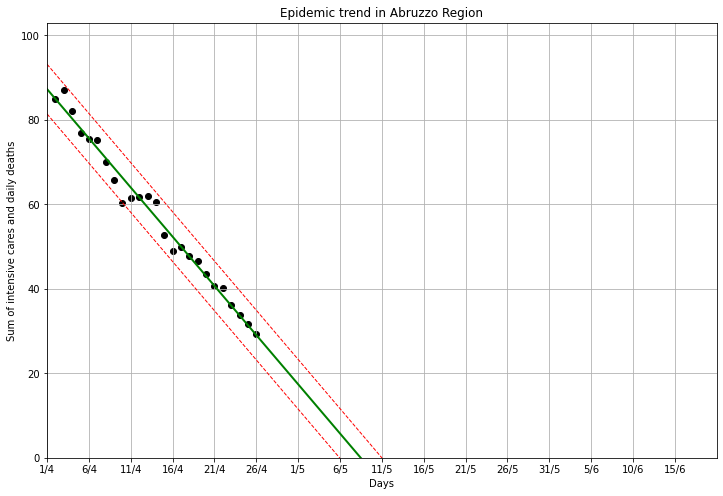

Abruzzo Zero intensive cares and deaths expected between 11/05/2020 and 05/05/2020
Creating model for Basilicata
Score : 0.9507590713060535


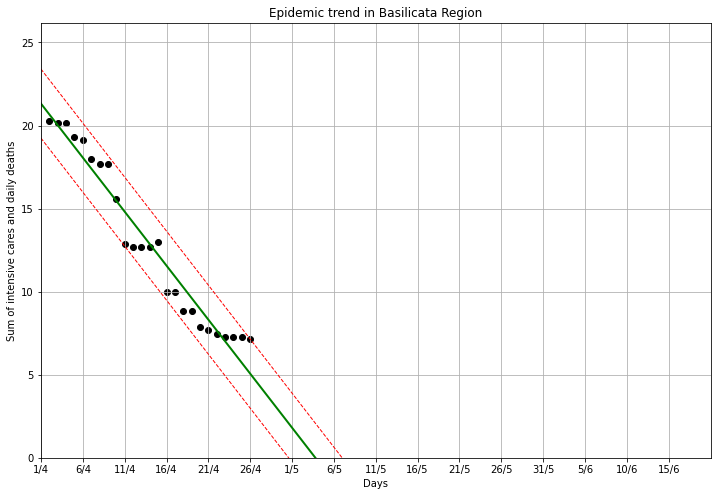

Basilicata Zero intensive cares and deaths expected between 07/05/2020 and 30/04/2020
Creating model for Calabria
Score : 0.8991450441156491


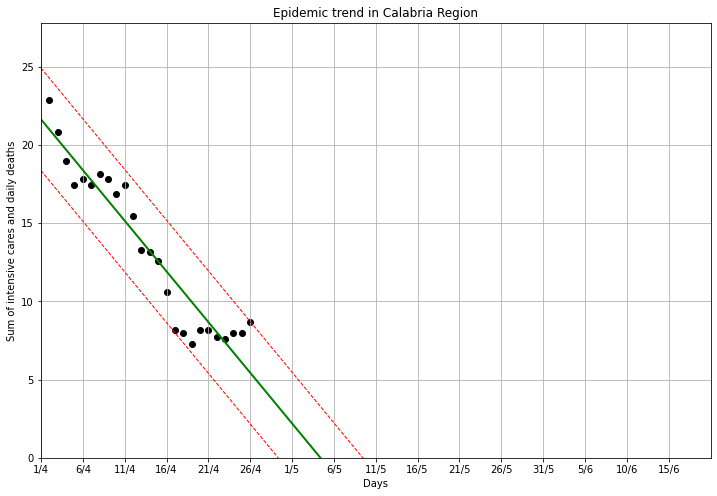

Calabria Zero intensive cares and deaths expected between 10/05/2020 and 29/04/2020
Creating model for Campania
Score : 0.9632873922021352


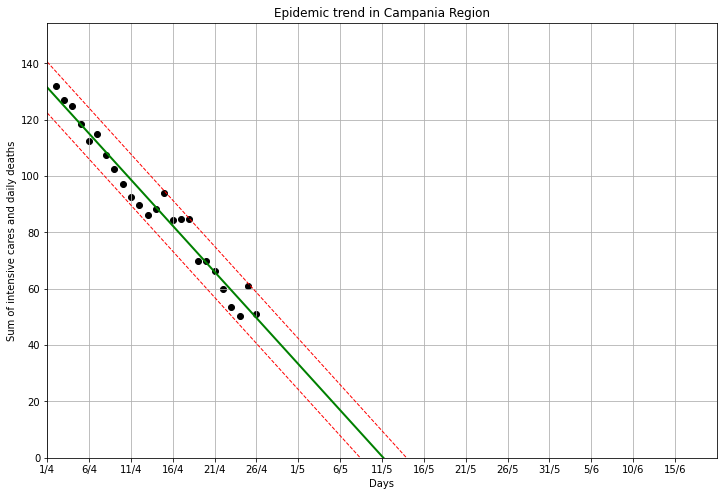

Campania Zero intensive cares and deaths expected between 14/05/2020 and 08/05/2020
Creating model for Emilia-Romagna
Score : 0.9686228113264405


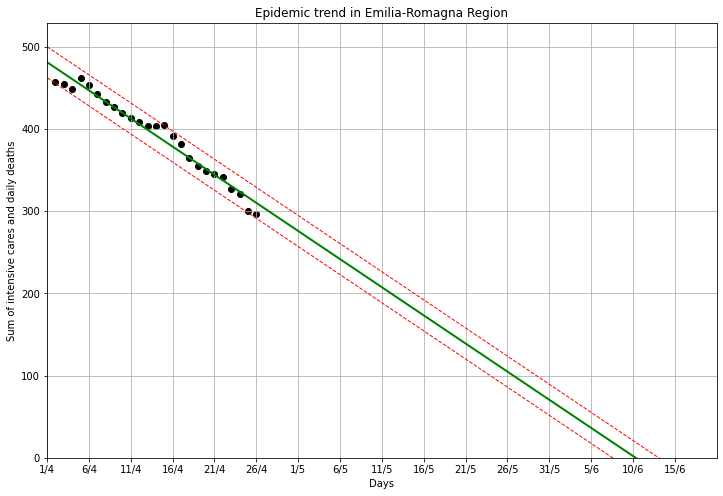

Emilia-Romagna Zero intensive cares and deaths expected between 14/06/2020 and 07/06/2020
Creating model for Friuli Venezia Giulia
Score : 0.897290181764567


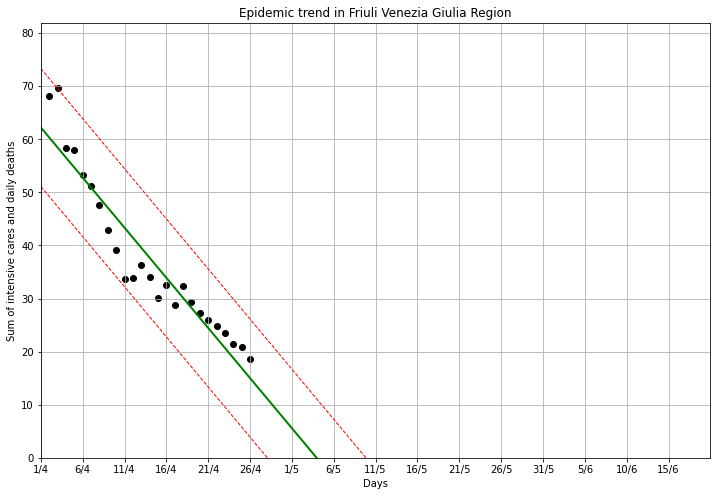

Friuli Venezia Giulia Zero intensive cares and deaths expected between 10/05/2020 and 28/04/2020
Creating model for Lazio
Score : 0.4078487316630822
Lazio Zero intensive cares and deaths expected between 02/01/2021 and 10/11/2020
Creating model for Liguria
Score : 0.9495044075715828


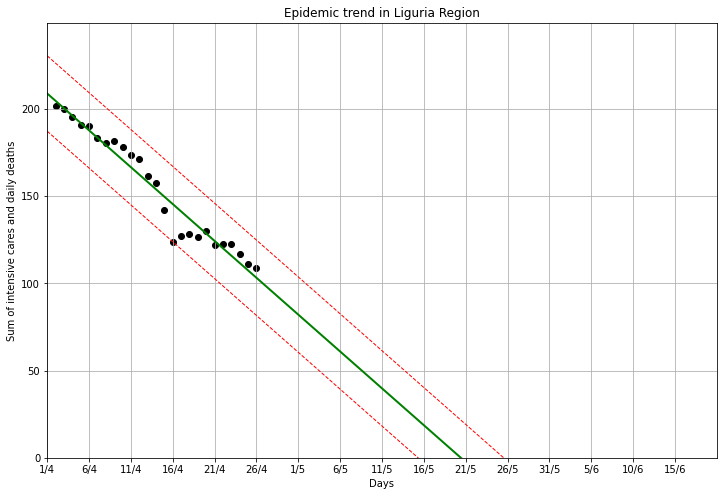

Liguria Zero intensive cares and deaths expected between 26/05/2020 and 15/05/2020
Creating model for Lombardia
Score : 0.9975386305153009


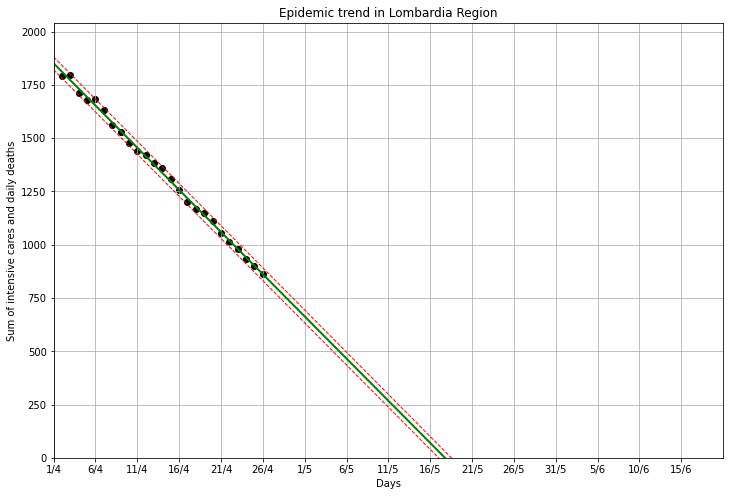

Lombardia Zero intensive cares and deaths expected between 19/05/2020 and 17/05/2020
Creating model for Marche
Score : 0.9861202257593434


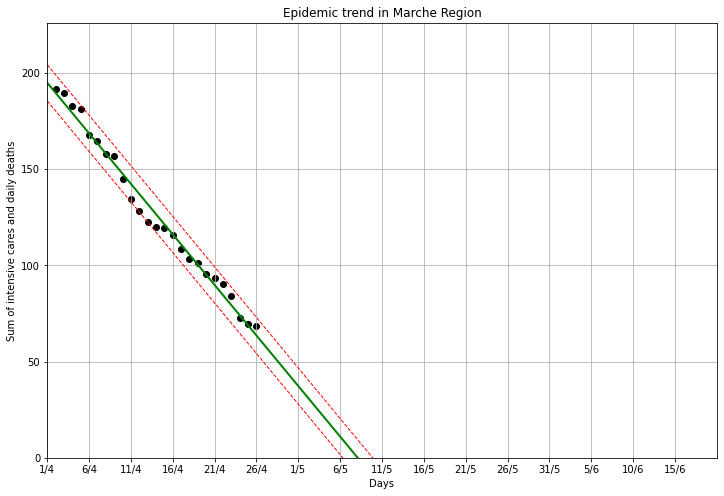

Marche Zero intensive cares and deaths expected between 10/05/2020 and 06/05/2020
Creating model for Molise
Score : 0.8455328921301386
Molise Zero intensive cares and deaths expected between 09/05/2020 and 26/04/2020
Creating model for Piemonte
Score : 0.9531894701717197


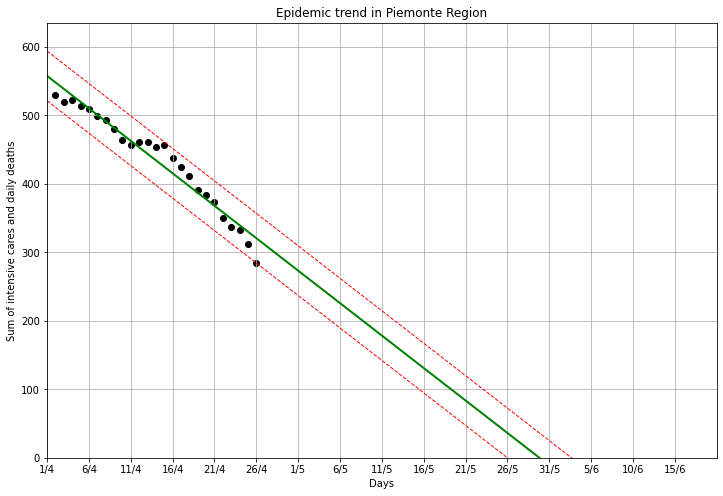

Piemonte Zero intensive cares and deaths expected between 03/06/2020 and 25/05/2020
Creating model for Puglia
Score : 0.7193035116166437
Puglia Zero intensive cares and deaths expected between 23/05/2020 and 25/04/2020
Creating model for Sardegna
Score : 0.5041257047074481
Sardegna Zero intensive cares and deaths expected between 19/07/2020 and 12/06/2020
Creating model for Sicilia
Score : 0.9764668581992016


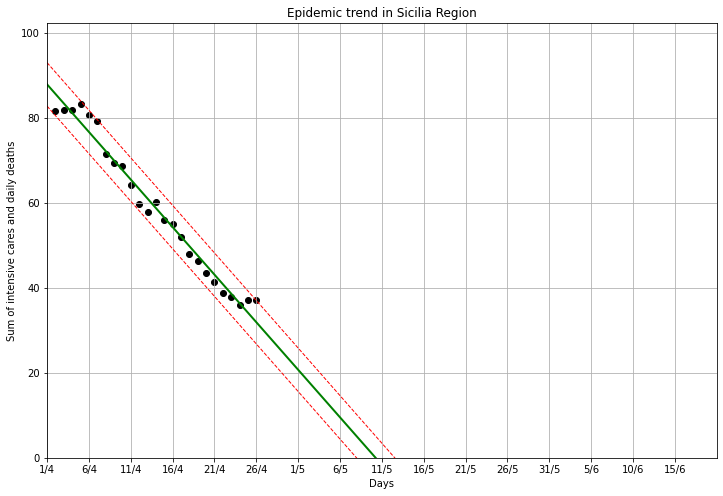

Sicilia Zero intensive cares and deaths expected between 13/05/2020 and 07/05/2020
Creating model for Toscana
Score : 0.985885762866495


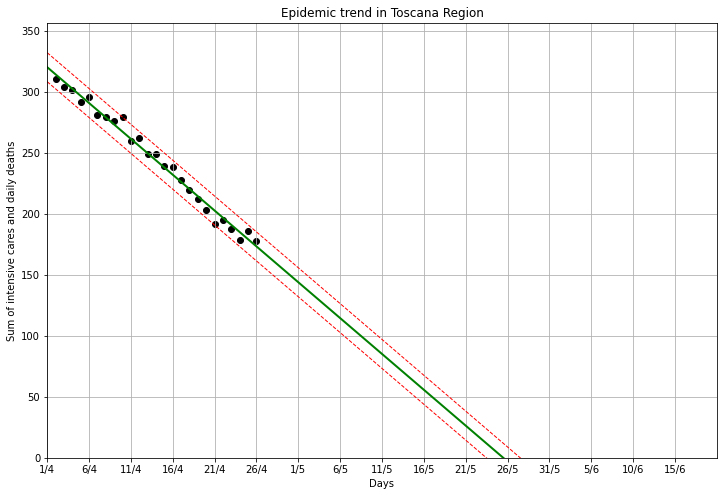

Toscana Zero intensive cares and deaths expected between 28/05/2020 and 23/05/2020
Creating model for Trentino Alto Adige
Score : 0.9636053342768119


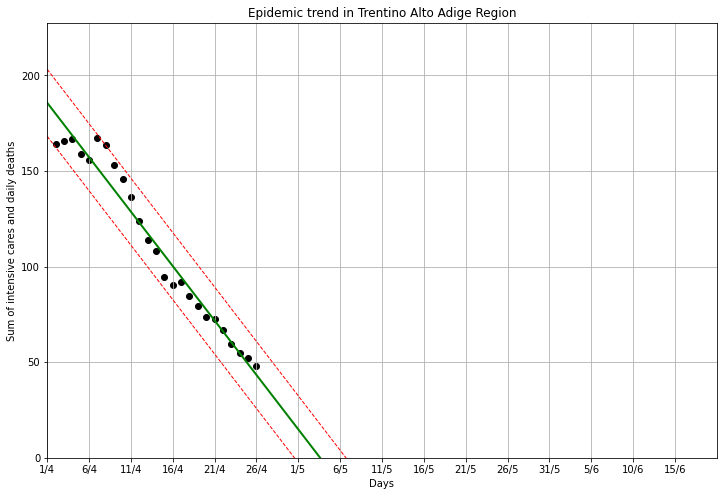

Trentino Alto Adige Zero intensive cares and deaths expected between 07/05/2020 and 30/04/2020
Creating model for Umbria
Score : 0.9544947125295166


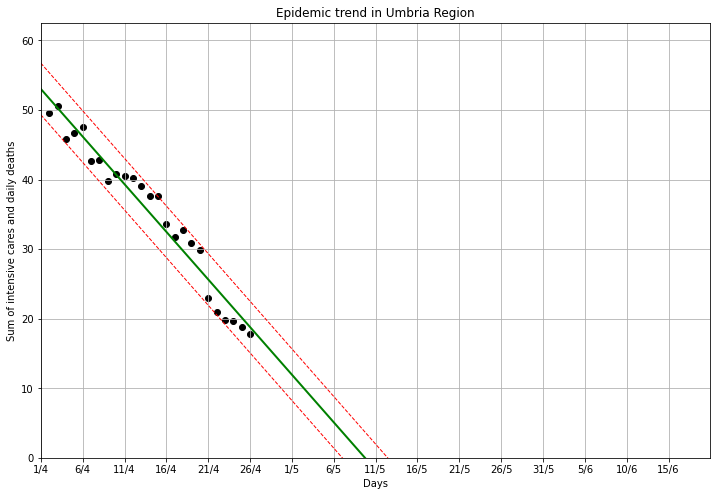

Umbria Zero intensive cares and deaths expected between 13/05/2020 and 07/05/2020
Creating model for Valle d'Aosta
Score : 0.962284500909581


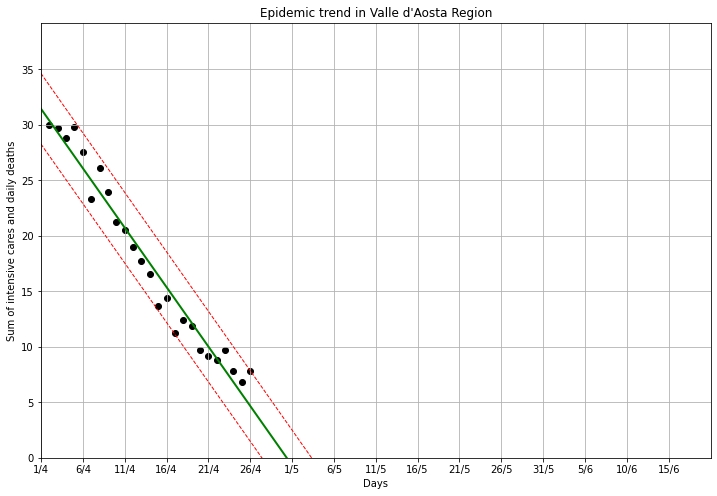

Valle d'Aosta Zero intensive cares and deaths expected between 04/05/2020 and 27/04/2020
Creating model for Veneto
Score : 0.9881279439539062


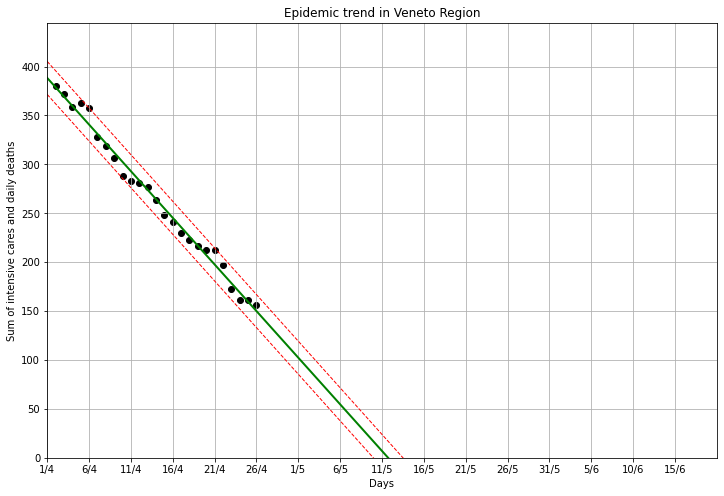

Veneto Zero intensive cares and deaths expected between 14/05/2020 and 09/05/2020


In [9]:
model_score_threshold = 0.85
model_outputs_df = pd.DataFrame()
for data in regional_df_list:
    date = data['data']
    region_name = data["denominazione_regione"].iloc[0]
    region_code = data["codice_regione"].iloc[0]
    print("Creating model for " + region_name)
    date_format = [pd.to_datetime(d) for d in date]
    # Creating Linear Regression Model
    linear_regr = linear_model.LinearRegression()
    # Preparing the lists with past data, that we will use for training the model
    X = date_format
    y = data['deaths_ICU'].tolist()[1:]
    # date format is not suitable for modeling, let's transform the date into incrementals number starting from April 1st
    peak_date_integer = 37  # April 1st is the 37th day of the series
    day_numbers = []
    for i in range(1, len(X)):
        day_numbers.append([i])
    X = day_numbers
    # Extracting data after the peak, that we will use for training the model
    X = X[peak_date_integer:]
    y = y[peak_date_integer:]
    # Train the model using the training sets
    linear_regr.fit(X, y)
    model_score = linear_regr.score(X, y)
    print("Score : %s" % (model_score))

    # Predict future trend
    y_pred = linear_regr.predict(X)
    error = max_error(y, y_pred)
    error
    X_test = []
    future_days = 80
    for i in range(peak_date_integer, peak_date_integer + future_days):
        X_test.append([i])
    y_pred_linear = linear_regr.predict(X_test)
    y_pred_max = []
    y_pred_min = []
    for i in range(0, len(y_pred_linear)):
        y_pred_max.append(y_pred_linear[i] + error)
        y_pred_min.append(y_pred_linear[i] - error)

    # convert date 0 into datetime format
    peak_date_dateformat = datetime.strptime(data['data'].iloc[peak_date_integer], '%Y-%m-%dT%H:%M:%S')
    # date forecast
    date_prev = []
    x_ticks = []
    step = 5
    data_curr = peak_date_dateformat
    x_current = peak_date_integer
    n = int(future_days / step)
    for i in range(0, n):
        date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
        x_ticks.append(x_current)
        data_curr = data_curr + timedelta(days=step)
        x_current = x_current + step

    if model_score >= model_score_threshold: 
        plt.title("Epidemic trend in %s Region" % region_name)
        # adjust plot size
        F = plt.gcf()
        Size = F.get_size_inches()
        F.set_size_inches(Size[0] * 2, Size[1] * 2, forward=True)
        # plot known data
        plt.scatter(X, y, color='black')
        # plot linear regression prediction
        plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
        # plot maximum error
        plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
        # plot minimum error
        plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
        plt.xlabel('Days')
        plt.xlim(peak_date_integer, peak_date_integer + future_days)
        plt.ylim(bottom=0)
        plt.xticks(x_ticks, date_prev)
        plt.ylabel('Sum of intensive cares and daily deaths')
        # plt.yscale("log")
        # add grid
        plt.grid()
        plt.savefig("prediction.png")
        plt.show()


    date_zero_datetime, date_zero_max, date_zero_min, remaining_days = calculate_date_zero(linear_regr)
    print("%s Zero intensive cares and deaths expected between %s and %s" % (region_name, date_zero_max, date_zero_min))

    temp = pd.DataFrame(
        {
            'region_name': region_name,
            'COD_REG': int(region_code),
            'remaining_days': remaining_days,
            'date_zero': date_zero_datetime,
            'date_zero_max': date_zero_max,
            'date_zero_min': date_zero_max,
            'model_score': model_score
        }, index=[region_code]
    )

    model_outputs_df = pd.concat([model_outputs_df, temp])

### Understanding models' outputs
We are almost done! This is how model_outputs_df looks like:

In [10]:
pd.set_option('display.width', 1000)
print(model_outputs_df)

              region_name  COD_REG  remaining_days   date_zero date_zero_max date_zero_min  model_score
13                Abruzzo       13              11  08/05/2020    11/05/2020    11/05/2020     0.983669
17             Basilicata       17               7  04/05/2020    07/05/2020    07/05/2020     0.950759
18               Calabria       18               7  04/05/2020    10/05/2020    10/05/2020     0.899145
15               Campania       15              14  11/05/2020    14/05/2020    14/05/2020     0.963287
8          Emilia-Romagna        8              44  10/06/2020    14/06/2020    14/06/2020     0.968623
6   Friuli Venezia Giulia        6               7  04/05/2020    10/05/2020    10/05/2020     0.897290
12                  Lazio       12             223  06/12/2020    02/01/2021    02/01/2021     0.407849
7                 Liguria        7              23  20/05/2020    26/05/2020    26/05/2020     0.949504
3               Lombardia        3              21  18/05/2020  

The column model_score is particularly important, it is the R² coefficient that tells us how well the models performed, therefore  how trustworthy and reliable are  the predictions for every region.

In order to have in the same dataframe both the model outputs and the most recent COVID data for each region, let's download the latest regional COVID csv from the Civil Protection GitHub repository, and join it to our model_outputs_df DataFrame.

In [11]:

#joining known latest data to regions
latest_regional_data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv")
df_no_04 = latest_regional_data[latest_regional_data.codice_regione != 4]
df_only_04 = latest_regional_data[latest_regional_data.codice_regione == 4]
df_only_04_sum = df_only_04.groupby(['data','lat','long','stato',], as_index=False)[["terapia_intensiva", "deceduti","ricoverati_con_sintomi","totale_ospedalizzati","isolamento_domiciliare","totale_positivi","variazione_totale_positivi",'nuovi_positivi','dimessi_guariti','totale_casi',"tamponi","casi_testati"]].sum()
df_only_04_sum['denominazione_regione'] = 'Trentino Alto Adige'
df_only_04_sum['codice_regione'] = 4
df_clean = df_no_04.append(df_only_04_sum)
df_clean['COD_REG'] = df_clean['codice_regione']


model_outputs_with_latest_data = model_outputs_df.merge(df_clean, on='COD_REG')
#exporting dataframe to csv
today = datetime.today()
model_outputs_with_latest_data.to_csv('model_outputs_%s%02d%s.csv' % (today.year, today.month, today.day))



### Mapping models' performance
Now the geospatial geek who lives inside of me can finally get some satisfaction: the best way to visualize the different reliabilities of the regional models is to display them on a map, and we will do that using geopandas and mapclassify libraries. Boundaries of Italian Regions can be downloaded as a shapefile from the Italian National Institute of Statistics' website.

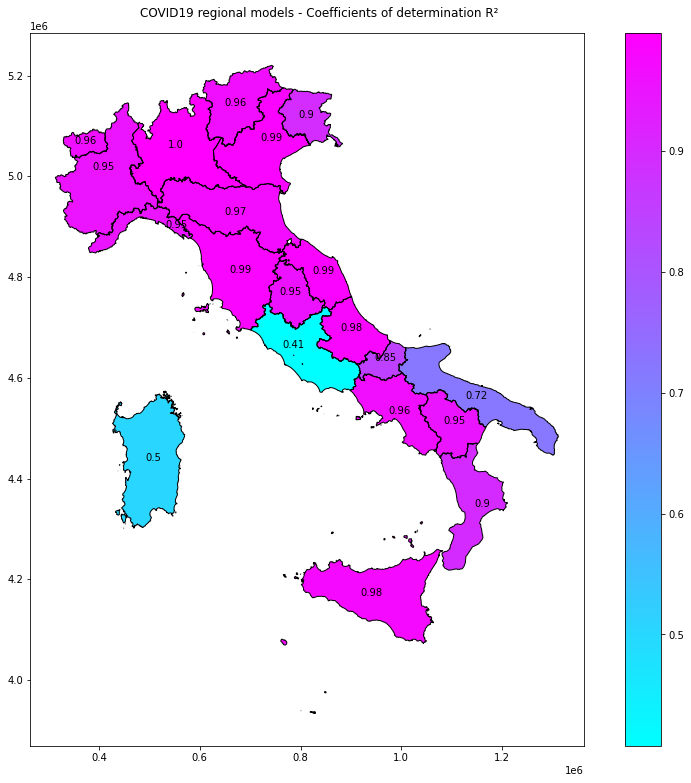

In [12]:
#importing mapping libraries
import geopandas as gpd
import os
#opening shapefile
df = gpd.read_file(os.path.join("/Users/andrea/Downloads/Limiti01012018_g 3/Reg01012018_g",'Reg01012018_g_WGS84.shp'))
#joining model outputs to the shapefile
#map settings
df = df.merge(model_outputs_df, on='COD_REG')
fig, ax = plt.subplots(figsize = (15,12))
fig.subplots_adjust(top=0.95)
fig.suptitle('COVID19 regional models - Coefficients of determination R²',fontsize = 12)
df.plot(column = 'model_score',cmap = 'cool',ax=ax, legend=True)
df.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) 
#adding labels
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=str(round(row['model_score'],2)), xy=row['coords'],
                 horizontalalignment='center')
plt.savefig("COVID_model_scores_map.png")

The above map shows how the models' reliability varies considerably according the region. The best performing model among the ones we built and trained is the one associated to Lombardia region. With its R² higher than 0.99, the model perfectly follows the data series, and we can expect the estimation to be fairly reliable also in the future. On the opposite side of spectrum we find Lazio region. 
In this case, the coefficients of determination R² is only about 0.35. As a consequence, the predictions are less reliable and associated with a particularly high margin of error. This is mainly due to the fact that the epidemic trend in this region is not following a linear trend, therefore the predictions provided by the model shouldn't be considered valid.
### Mapping models' predictions
The key information provided by our models is the prediction of the epidemic end for each Italian region, expressed with the number of days needed before the variable deaths_ICU become equal to zero. Before even considering the reliability of these predictions, let's draw a map of the predictions across the country.

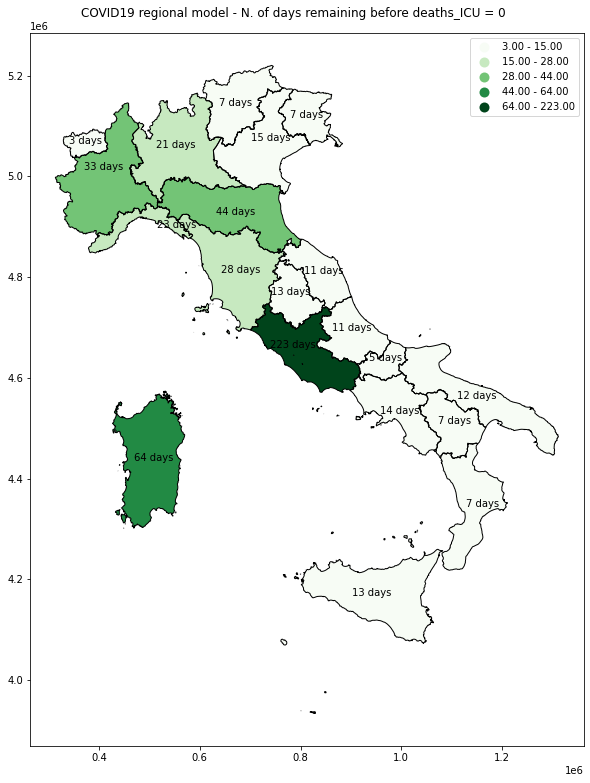

In [13]:
#opening shapefile
df = gpd.read_file(os.path.join("/Users/andrea/Downloads/Limiti01012018_g 3/Reg01012018_g",'Reg01012018_g_WGS84.shp'))
#joining model outputs to the shapefile
#map settings
df = df.merge(model_outputs_df, on='COD_REG')
fig, ax = plt.subplots(figsize = (15,12))
fig.subplots_adjust(top=0.95)
fig.suptitle('COVID19 regional model - N. of days remaining before deaths_ICU = 0',fontsize = 12)
df.plot(column = 'remaining_days',cmap = 'Greens',ax=ax, legend=True, scheme='FisherJenks')
df.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) 
#adding labels
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=str(row['remaining_days']) + " days", xy=row['coords'],
                 horizontalalignment='center')
plt.savefig("COVID_regional_models_map_nofilter.png")

### Combining predictions with models reliability.
The very last step consists of combining the predictions of the regional models with their reliability scores. In other words, we want to exclude from our final map all the regions where our models didn't perform well. For doing this, we set an arbitrary threshold for the minimum acceptable model_score, and we display on the map only the regions for which our predictions are more reliable.

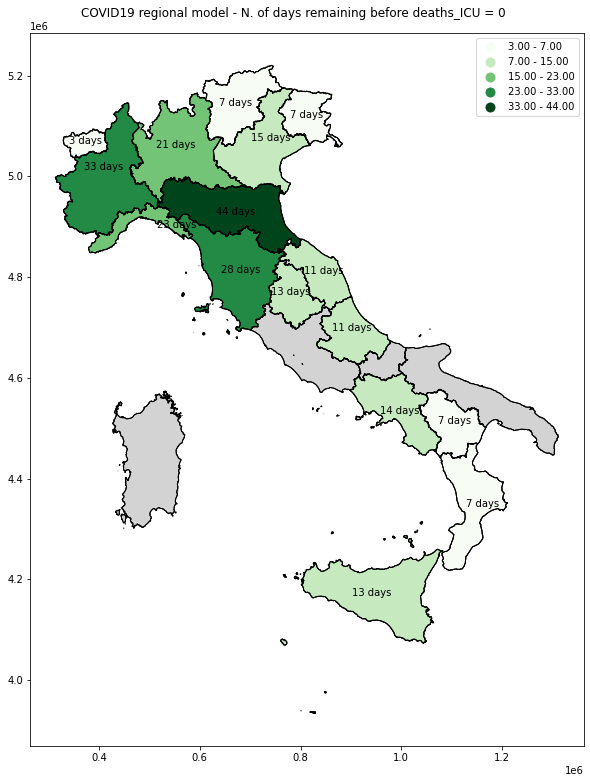

In [14]:
#opening shapefile
df = gpd.read_file(os.path.join("/Users/andrea/Downloads/Limiti01012018_g 3/Reg01012018_g",'Reg01012018_g_WGS84.shp'))
background = df

model_outputs_df_filtered = model_outputs_df[model_outputs_df['model_score'] > model_score_threshold]

#joining model outputs to the shapefile
df = df.merge(model_outputs_df_filtered, on='COD_REG')
#map settings
fig, ax = plt.subplots(figsize = (15,12))
fig.subplots_adjust(top=0.95)
fig.suptitle('COVID19 regional model - N. of days remaining before deaths_ICU = 0',fontsize = 12)

df.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) 
background.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) 
background.plot(color='lightgray',edgecolor='k',linewidth = 1,ax=ax, legend=True) 
df.plot(column = 'remaining_days',cmap = 'Greens',ax=ax, legend=True, scheme='FisherJenks')
#adding labels
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=str(row['remaining_days']) + " days", xy=row['coords'],
                 horizontalalignment='center')
    
plt.savefig("COVID_regional_models_map.png")

### Cleaning output table and saving csv 
Finally, we can salve the models' predictions in a csv file, filtering out the outputs coming from not reliable models.

In [15]:
export_table = model_outputs_df.copy()
export_table.loc[export_table['model_score'] < model_score_threshold, 'remaining_days'] = 'No Data'
export_table.loc[export_table['model_score'] < model_score_threshold, 'date_zero_min'] = 'No Data'
export_table.loc[export_table['model_score'] < model_score_threshold, 'date_zero_max'] = 'No Data'
export_table.loc[export_table['model_score'] < model_score_threshold, 'date_zero'] = 'No Data'
export_table.sort_index(inplace=True)
del export_table['COD_REG']
print(export_table)
export_table.to_csv('export_table_%s%02d%s.csv' % (today.year, today.month, today.day))

              region_name remaining_days   date_zero date_zero_max date_zero_min  model_score
1                Piemonte             33  30/05/2020    03/06/2020    03/06/2020     0.953189
2           Valle d'Aosta              3  30/04/2020    04/05/2020    04/05/2020     0.962285
3               Lombardia             21  18/05/2020    19/05/2020    19/05/2020     0.997539
4     Trentino Alto Adige              7  04/05/2020    07/05/2020    07/05/2020     0.963605
5                  Veneto             15  12/05/2020    14/05/2020    14/05/2020     0.988128
6   Friuli Venezia Giulia              7  04/05/2020    10/05/2020    10/05/2020     0.897290
7                 Liguria             23  20/05/2020    26/05/2020    26/05/2020     0.949504
8          Emilia-Romagna             44  10/06/2020    14/06/2020    14/06/2020     0.968623
9                 Toscana             28  25/05/2020    28/05/2020    28/05/2020     0.985886
10                 Umbria             13  10/05/2020    13/0

### Conclusions
The predictions of the regional Linear Regression models we built and trained in this exercise are summarized in the table above.
As explained before, the higher the model score and the more reliable is the prediction. For this reason, outputs of low scoring models have been excluded from this recap table and from the final map.
This article aimed at predicting the end of COVID-19 epidemic in Italy, taking in consideration the regional differences and trends. Like for any modeling exercise, we have to consider that any new external factor can change the effective evolution of the epidemic. Models can not take into account unexpected changes in the system, such as the gradual loosening of lockdown restrictions (expected in Italy after May 4th), or the effects of warmer temperature over the virus spread. Such changes in the system could have an impact and change the linear trends we have observed.
From a more general perspective, the results of our analyses highlight the great heterogeneity of the COVID outbreak in Italy, with some region recovering much faster than others. Moreover, visualizing those predictions on a map gives us a clearer overview and helped us to get a better understanding on the epidemic situation.